In [6]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)

import warnings
# warnings.filterwarnings(action='once') #useful to see a warning once but that's it
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

from transitleastsquares import catalog_info
from transitleastsquares import period_grid

import wotan
from wotan import flatten


from astroML.time_series import lomb_scargle

In [2]:

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]

    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

In [3]:
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  917


## Let's compare with our previous pipeline using Lightkurve's detrending with the new Wotan tools:

See https://github.com/hippke/wotan for more details.


In [4]:
# # for ii in range(len(data)): #creating a for loop to show light curve figures for all files
# for ii in range(10): #creating a for loop to show light curve figures for all files    
#     print(ii)
#     time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
#     mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
#     magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    
#     mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
#     time = time[mask]                        #Sometimes there are holes in data filled with NaNs
#     mag = mag[mask]
#     magerror = magerror[mask]
    
#     flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
#     fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
#     #known bad data points:
#     if SectorNum==1:
#         jittermask = (time < 1346) | (time > 1350)
    
#     #removing outliers with Chauvenet's criterion
#     t2,f2,fe2 = ChauventsCriteron(time[jittermask],flux[jittermask],fluxerror[jittermask])
    
#     lc = lk.LightCurve(t2,f2,fe2)
    
#     bin_size = 5
#     cad = time[1]-time[0]
#     #now let's define a window size to smooth our data with:

#     window_size = int(3.0/cad) #number of data points in 5 hours
#     if (window_size % 2) == 0: #must be odd. If not, there will be an error
#         window_size = window_size+1
        
#     detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)
    
#     window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
#     flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, method='biweight',robust=True)


#     nanmask = np.where(np.isnan(flatten_lc)==False)[0]
#     t2 = t2[nanmask]
#     f2 = f2[nanmask]
#     fe2 =fe2[nanmask]

#     flatten_lc = flatten_lc[nanmask]
#     trend_lc = trend_lc[nanmask]
# #     Try another iteration of outlier removal
#     t2_wotan,f2_wotan,fe2_wotan = ChauventsCriteron(t2,flatten_lc,fe2)
    
#     fig = plt.figure(figsize=(10,6))
#     ax1 = fig.add_subplot(211)
#     ax1.plot(lc.time,lc.flux,color='grey',marker='.',linestyle='none')
#     for x in range(12):
#         plt.axvline(x=(t2[0]+x*2.5),color='b')
#     ax1.plot(detrended_lc.time,detrended_lc.flux,color='red',marker='.',linestyle='none')
#     ax1.set_xlabel("Time (TJD)")
#     ax1.set_ylabel("Normalized Relative Flux")
    
#     ax2 = fig.add_subplot(212)
#     ax2.plot(lc.time,lc.flux,color='grey',marker='.',linestyle='none')
#     ax2.plot(t2,trend_lc,'k')
#     offset = 0.015
#     ax2.plot(detrended_lc.time,detrended_lc.flux-offset,color='red',marker='.',linestyle='none')
#     ax2.plot(t2_wotan,f2_wotan-offset,color='green',marker='.',linestyle='none')
#     for x in range(12):
#         plt.axvline(x=(t2[0]+x*2.5),color='b')

#     plt.axhline(y=np.mean(f2_wotan)+3*np.std(f2_wotan)-offset,color='orange')
#     plt.axhline(y=np.mean(f2_wotan)-3*np.std(f2_wotan)-offset,color='orange')
#     ax2.set_xlabel("Time (TJD)")
#     ax2.set_ylabel("Normalized Relative Flux") 
#     plt.show()

## In figures above, the grey and black lines are the undetrended data with modeled trends in black. The green data is our new flattened data and the red data is our old method using LightKurve. The yellow horizontal lines are the mean + 3 standard deviations of the green data. The Blue lines are the 2.5 momentum dump rate for this sector. For most data sets, it appears the outliers due to the momentum dumps are removed. Hopefully, this takes care of that bias in our BLS/TLS results.

## Let's try BLS with these green results. Most 2.5 day momentum dump outliers are minimized but remain, let's see if this is an issue.

SDE Threshold:  6.0
 
iteration 1
LS period:  2.8216715369959116
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.026922286699271 < 6.0
 
iteration 2
LS period:  2.3719081357869896
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
No R_star and M_star
 
iteration 3
LS period:  2.635933564804775
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.756860113290098 < 6.0
 
iteration 4
LS period:  2.1783761244921362
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  3.2931698094318778 < 6.0
 
iteration 5
LS period:  2.5304121370332875
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.648810974590877 < 6.0
 
iteration 6
LS period:  1.2005434809624562
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  3.807141491062603 < 6.0
 
iteration 7
LS period:  2.323947247901957
Applying Quasi Perio

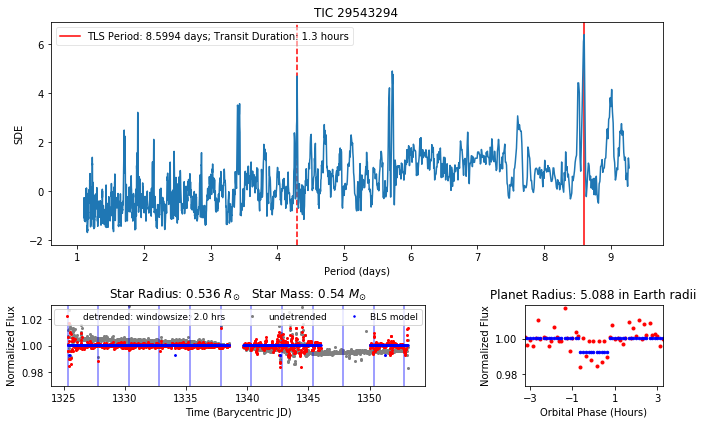


 
iteration 10
LS period:  2.9493631885181477
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.1820746873582655 < 6.0
 
iteration 11
LS period:  2.445711712802392
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
 
file:
TIC  29717846   4   1   Sector01
best period:  6.902856716462214
best T0:  0.2057344392549112


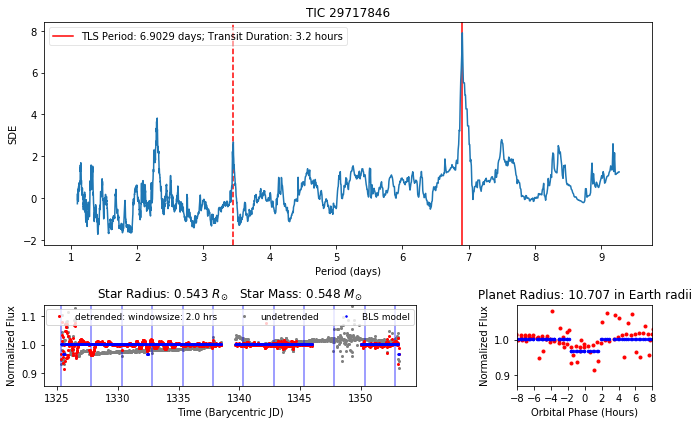


 
iteration 12
LS period:  1.6990066511044004
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  5.618074278429557 < 6.0
 
iteration 13
LS period:  2.582633981964037
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
No R_star and M_star
 
iteration 14
LS period:  2.0628862005865476
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  5.455565600531501 < 6.0
 
iteration 15
LS period:  2.5651080369912007
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.673248466150443 < 6.0
 
iteration 16
LS period:  2.30817677021486
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
 
file:
TIC  31530505   2   4   Sector01
best period:  2.367168639101988
best T0:  2.2331997419887037


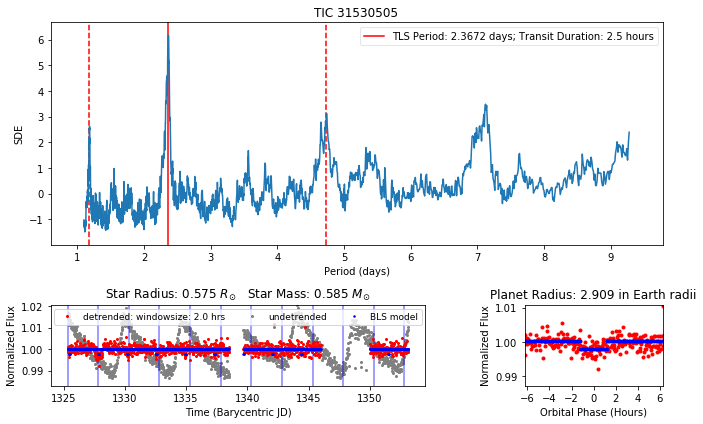


 
iteration 17
LS period:  2.084064089251484
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  3.973540168216297 < 6.0
 
iteration 18
LS period:  2.6002796718921597
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  3.650521955914891 < 6.0
 
iteration 19
LS period:  2.1932597471456186
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.031404964866674 < 6.0
 
iteration 20
LS period:  1.8187251653829497
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.820156051272551 < 6.0
 
iteration 21
LS period:  2.71795247730916
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
 
file:
TIC  31798176   4   3   Sector01
best period:  2.442109379181577
best T0:  1.401346771070255


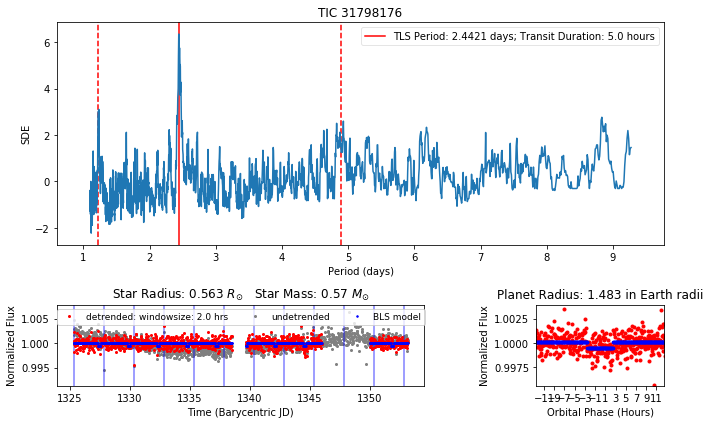


 
iteration 22
LS period:  2.635933564804775
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.180972723600295 < 6.0
 
iteration 23
LS period:  0.6244342583637068
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  2.833713123547997 < 6.0
 
iteration 24
LS period:  2.708714665373076
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.632200040827266 < 6.0
 
iteration 25
LS period:  1.831151494687427
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
BLS peak:  4.627617833781425 < 6.0


In [27]:
spacing = 0.02

SDE_threshold=6.0 #we've been testing different values here (6,6.5,7). For now, let's try sticking with 6.

fs = 9
#for reporting BLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

print("SDE Threshold: ", SDE_threshold)

#creating empty lists to be filled then saved for planet candidates
ids=[]
cams=[]
ccds=[]
mstar=[]
rstar=[]
rplanet=[]
per=[]
transdur=[]
sdes=[]

# for ii in range(len(data)): #creating a for loop to show light curve figures for all files
for ii in range(25): #creating a for loop to show light curve figures for all files

    
    time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    mask = np.where(np.isfinite(mag)==True)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    flux = flux[mask]
    fluxerror = fluxerror[mask]
    
    
    #known bad data points with high telescope jitter:
    SectorNum = int((os.path.basename(data[ii]).split)('_')[1][6:])
    if SectorNum==1:
        jittermask = (time < 1346) | (time > 1350)
        mdumps=2.5
    
        
        t1,f1,fe1 = time[jittermask], flux[jittermask], fluxerror[jittermask]
        #removing outliers with Chauvenet's criterion
#         t2,f2,fe2 = ChauventsCriteron(t1,f1,fe1)

        t2,f2,fe2=t1,f1,fe1
    else:
        
#         t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror)
        
        t2,f2,fe2=time,flux,fluxerror
    
    if SectorNum==3:
        jittermask = (time < 1382.6) | (time > 1383.65)
        mdumps=3.125
        
        t1,f1,fe1 = time[jittermask], flux[jittermask], fluxerror[jittermask]
        #removing outliers with Chauvenet's criterion
#         t2,f2,fe2 = ChauventsCriteron(t1,f1,fe1)
    
        t2,f2,fe2=t1,f1,fe1

#     print(shape(clipped_flux),shape(time))
    lc = lk.LightCurve(t2,f2,fe2) #outlier removed only
    
    #check for rapid rotators with Lomb-Scargle (P_rot < 2 days)
    period = 10 ** np.linspace(np.log10(0.1), np.log10(3), 1000)
    freq = 2.0 * np.pi / period
    PS = lomb_scargle(t2,f2,fe2,omega=freq, generalized=True)
    Standpower = (PS-np.mean(PS))/np.std(PS)
    print(" ")    
    print("iteration",ii+1)
    print("LS period: ",period[np.argmax(Standpower)])
    
    if period[np.argmax(Standpower)] < 3:

        print("Applying Quasi Periodic GP...")
        length_scale=2 # 1 to 2 is generally pretty good from my tests
        gpflatten_lc, gptrend_lc = flatten(t2,f2,method='gp', \
                                             kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)
        
        T=t2
        F= gpflatten_lc
        FE = fe2
        
        #might break here
#         flatten_lc, trend_lc = flatten(T,F,method='hspline',window_length=0.5,break_tolerance=0.5,return_trend=True)
        
        T,F,FE = ChauventsCriteron(T,F,FE)
        flatten_lc, trend_lc = flatten(T,F,method='savgol',window_length=241,cval=3,return_trend=True)
        
        
        nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
        T = T[nanmask]
        F = flatten_lc[nanmask]/np.mean(flatten_lc[nanmask])
        FE =FE[nanmask]
        
#         #try re-flattening after GP fit
#         flatten_lc, trend_lc = flatten(T, F, window_length=5/24.0, return_trend=True, break_tolerance=window_size_wotan/2.0,method='biweight',robust=True)
#         T=T
#         F=flatten_lc
#         FE=FE
        
        
#         nanmask = np.where(np.isfinite(F)==True)[0]
#         T = T[nanmask]
#         F = F[nanmask]/np.mean(F[nanmask])
#         FE =FE[nanmask]
        
        window_size_wotan = length_scale/24.0
    else:

        print("Applying Biweighted Midcorrelation Function...")
        window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
        flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, break_tolerance=window_size_wotan/2.0,method='biweight',robust=True)
        T=t2
        F=flatten_lc
        FE=fe2
        T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]


#     Try another iteration of outlier removal
#     T,F,FE = ChauventsCriteron(T,F,FE) #<--- may cause inaccurate transit depths
#     T,F,FE = t2,f2,fe2
        
    #Another way of doing outlier removal: +/- some horizontal cut (in standard deviations)
#     ff= sigma_clip(F, sigma_upper=3, sigma_lower=7)
#     nanmask = np.where(np.isnan(ff)==False)[0]
#     T = T[nanmask]
#     F = ff[nanmask]
#     FE =FE[nanmask]
    
    ID = (os.path.basename(data[ii]).split)('_')[0]


    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    
    #doing BLS search:
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))   
    #^^^ grabbing stellar information from MAST catalogs
    
    if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
        minP=1.1
        maxP= (max(T)-min(T)) #length of our light curve
        minDur = 1.0/24.0
        maxDur = 5.0/24.0
        
        #creating list of orbital periods to model with
        periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

        durations = np.linspace(minDur,maxDur,25)
    
        bls = BoxLeastSquares(T,F,FE)
        bls_power = bls.power(periods, durations)
        bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)
        
        #phase folding with best BLS model
        index = np.argmax(bls_power.power); 
        best_period = bls_power.period[index]; 
        best_duration = bls_power.duration[index]
        best_t0 = bls_power.transit_time[index];
        BLS_depths=bls_power.depth[index]
        dur = minDur #0.5

        #creating the best fit box model to our data
        bls_model=bls.model(T,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])
        
        #calculating planet radius fit by BLS
        R_p = np.sqrt(BLS_depths)*R_star*R_sun/R_earth
        
        
        p = best_period
        x_fold = (T - best_t0 + 0.5*p) % p - 0.5*p
        x_fold_raw = (time - best_t0 + 0.5*p) % p - 0.5*p
        
        detrendedphasefoldedlc = [x_fold, F, FE]
        phasefoldedlc = [x_fold_raw,flux,fluxerror]


        if len(np.where(bls_SDE>SDE_threshold)[0])>0:
            print(" ")
            print("file:")
            print("TIC ", ID, " ",CCD, " ",Camera, " ",Sector)
            print("best period: ", best_period)
            print("best T0: ",best_t0)

            gs1 = gridspec.GridSpec(3, 3)
            gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


            f = plt.figure(figsize=(10,6))
            ax1 = f.add_subplot(gs1[:-1, :])
            ax2 = f.add_subplot(gs1[-1, :-1])
            ax3 = f.add_subplot(gs1[-1, -1])

            ax1.axvline(x=best_period,color='r',label='TLS Period: '+str( np.round(best_period,4) )+" days; Transit Duration: "+str(np.round(24*best_duration,4))+" hours") #rounding period to 4 decimal places 
            ax1.axvline(x=0.5*best_period,color='r',linestyle='--')
            ax1.axvline(x=2.0*best_period,color='r',linestyle='--') 
            ax1.plot(bls_power.period, bls_SDE, rasterized=True)
            ax1.set_xticks(np.arange(1.0, 15.0, 1.0))
            ax1.set_title("TIC "+ ID)
            ax1.set_xlabel("Period (days)")
            ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
            ax1.set_ylabel("SDE")
            ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)
            ax1.legend(loc='best',fancybox=True,framealpha=0.5)

            ax2.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')#+", binsize: "+str(bin_size)) 
            ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
            ax2.plot(T,bls_model,'b.',markersize=3,label='BLS model')
            ax2.legend(loc='upper center',ncol=3,fontsize=fs)
#             ax2.set_ylim(np.min(f2_wotan)-spacing, np.max(f2_wotan)+spacing)
            ax2.set_ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F))
            ax2.set_xlabel("Time (Barycentric JD)")
            ax2.set_ylabel("Normalized Flux") 
            ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")
            for x in range(12):
                ax2.axvline(x=(T[0]+x*mdumps),color='b',alpha=0.5,zorder=0)
            
            
            ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24))#+", binsize: "+str(bin_size))
#             ax3.plot(24*x_fold_raw,phasefoldedlc[1],c='grey',marker='.',markersize=6,linestyle='none',zorder=0,label='undetrended')
            ax3.plot(24*x_fold,bls_model,'b.',markersize=5,label='BLS model')
            ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
            ax3.set_xlabel("Orbital Phase (Hours)")
            ax3.set_ylabel("Normalized Flux") 
#             ax3.set_ylim(np.min(bls_model)-spacing+0.01, np.max(bls_model)+spacing-0.01)
            ax3.set_ylim(np.min(bls_model)-25*np.std(bls_model), np.max(bls_model)+25*np.std(bls_model))
#             ax3.set_xticks(np.arange(-10,15,2)) #hours
            ax3.set_xticks(np.arange(np.round(-7*best_duration*24.0),np.round(7*best_duration*24.0),2)) #hours
            ax3.set_xlim(-2.5*best_duration*24,2.5*best_duration*24)
            gs1.tight_layout(f)

            plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_BLS.png")
            plt.show()    
            print( "") #adds space between figures
            
            
            ids.append(ID)
            ccds.append(CCD)
            cams.append(Camera)
            rstar.append(R_star)
            mstar.append(M_star)
            rplanet.append(R_p)
            per.append(best_period)
            transdur.append(best_duration)
            sdes.append(np.max(bls_SDE))
        else:
            print("BLS peak: ",np.max(bls_SDE),"<",SDE_threshold)
    else:
        print("No R_star and M_star")
        continue
        print(" ") #adds space between figures
        
        

In [20]:
print("done!")

done!


In [21]:
ls=np.array([ids,cams,ccds,rstar,mstar,rplanet,per,transdur,sdes])
# print(shape(ls))
ls = ls.astype(np.float) #turns strings into floats
lsx = sorted(np.transpose(ls), key=lambda x: x[8],reverse=True) #sort by SDE with highest at top of list
# print(lsx)


header='%1s\t%10s\t%1s\t%1s\t%13s\t%13s\t%19s\t%30s\t%7s'%('ids','cams','ccds','rstar(solar)','mstar(solar)','rplanet','period(d)','transitduration(d)','SDE')
np.savetxt("Sector_01_PlanetCandidates_BLS.txt",lsx,header=header,delimiter='\t',fmt='%s')

